## Differentiating MLB batters with Offensive Performance


The purpose of this project is to reduce the gap between sabermetrics and scouts by offering a
simple and visualized approach to identify players with similar and exceptional offensive ability by
using only the basic baseball statistics, which the scouts and managers are comfortable with.

The anaylysis will be split into 4 parts:
* Data Cleaning
* Data Exploration
* Model Building
* Results

### * Data Cleaning
1. Combine the Batting data and Batting Post data to get the batting data in the whole season.
2. Select players with at least 3 years records.
3. Calculate sabermetrics.
4. Remove the players with less than 30 records in feature of At Bats.

In [1]:
## Import library
import pandas as pd
import numpy as np 
import seaborn as sns # visualisation
from matplotlib import pyplot as plt
import squarify # treemap

from sklearn.preprocessing import StandardScaler # Standardise data
from sklearn.decomposition import PCA # PCA
from collections import Counter # get the number of instances in each label
import matplotlib.collections 
from sklearn.cluster import DBSCAN # DBSCAN
from sklearn.neighbors import LocalOutlierFactor # LOF
from sklearn import metrics
from sklearn.datasets import make_blobs

import warnings
warnings.filterwarnings("ignore")

In [2]:
## data loading

# data loading for batting statistics
path = "Batting.csv"
path_post = "BattingPost.csv"

df = pd.read_csv(path)
df_post = pd.read_csv(path_post)
df_batter = pd.read_csv("People.csv")



In [3]:
## Data cleaning

# select recent 3 years
df = df.loc[(df["yearID"] == 2019) |(df["yearID"] == 2018) |(df["yearID"] == 2017)]
df_post = df_post.loc[(df_post["yearID"] == 2019) |(df_post["yearID"] == 2018) |(df_post["yearID"] == 2017)]

# drop unneeded columns
df = df.drop(columns=['stint', 'teamID', 'lgID'])
df_post = df_post.drop(columns=['round', 'teamID', 'lgID'])
df_post

# convert float to int
ls = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']
df[ls] = df[ls].astype(int)
df['yearID'] = df['yearID'].astype(object)
#df.dtypes

df_post[ls] = df_post[ls].astype(int)
df_post['yearID'] = df_post['yearID'].astype(object)
#df_post.dtypes

In [4]:
## Data cleaning - do it in combined data

# combine two dataframes
df_index = df.set_index(['playerID', 'yearID'])
df_post_index = df_post.set_index(['playerID', 'yearID'])
df_com = pd.concat([df_index, df_post_index]).groupby(['playerID', 'yearID']).sum().reset_index().set_index(['playerID'])
#df_com

# select players have 3 year records
df_select = df_com[pd.Index(df_com.index).value_counts() == 3]
df_select.head()


,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,
abreujo02,2017,156,621,95,189,43,6,33,102,3,0,35,119,6,15,0,4,21
abreujo02,2018,128,499,68,132,36,1,22,78,2,0,37,109,7,11,0,6,14
abreujo02,2019,159,634,85,180,38,1,33,123,2,2,36,152,4,13,0,10,24
adamsau02,2017,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adamsau02,2018,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# metrics calculation
df_select['TB'] = df_select['H'] + 2 * df_select['2B'] + 3 * df_select['3B'] + 4 * df_select['HR']
df_select['BA'] = df_select['H'] / df_select['AB']
df_select['OBP'] = (df_select['H'] + df_select['BB'] + df_select['HBP']) / (df_select['AB'] + df_select['BB'] + df_select['HBP']+ 3 * df_select['SF'])


In [6]:
# metrics calculation

df_select['SLG'] = df_select['TB'] / df_select['AB']
df_select['OPS'] = df_select['OBP'] + df_select['SLG']
df_select['TA'] = (df_select['TB'] + df_select['BB'] + df_select['HBP'] + df_select['SB'] - df_select['CS']) / (df_select['AB'] - df_select['H'] + df_select['CS'] + df_select['GIDP'])

In [7]:
# metrics calculation
df_select['ISO'] = df_select['SLG'] - df_select['BA']
df_select['SECA'] = (df_select['TB'] - df_select['H'] + df_select['BB'] + df_select['SB'] - df_select['CS']) / df_select['AB']
df_select['RC'] = (df_select['H'] + df_select['BB'] + df_select['HBP'] - df_select['CS'] - df_select['GIDP']) * (df_select['TB'] + 0.26*(df_select['BB'] - df_select['IBB'] + df_select['HBP']) + 0.52*(df_select['SH']+df_select['SF']+df_select['SB'])) / (df_select['AB'] + df_select['BB']+ df_select['HBP']+df_select['SH']+df_select['SF'])
df_select['RC27'] = df_select['RC'] / (df_select['AB'] - df_select['H'] + df_select['SH'] + df_select['SF'] + df_select['CS'] + df_select['GIDP']) / 27


df_select.head()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,...,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27
playerID,,,,,,,,,,,,,,,,,,,,,
abreujo02,2017,156,621,95,189,43,6,33,102,3,...,425,0.304348,0.349927,0.684380,1.034307,1.055188,0.380032,0.441224,142.129541,0.011519
abreujo02,2018,128,499,68,132,36,1,22,78,2,...,295,0.264529,0.318584,0.591182,0.909766,0.905512,0.326653,0.404810,93.002025,0.008901
abreujo02,2019,159,634,85,180,38,1,33,123,2,...,391,0.283912,0.321178,0.616719,0.937897,0.916667,0.332808,0.389590,119.790505,0.009054
adamsau02,2017,6,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adamsau02,2018,2,0,0,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# fill nan with 0
df_select = df_select.replace([np.inf, -np.inf], np.nan)
df_select.fillna(0, inplace = True)

# check nan
df_select.isnull().sum()

yearID    0
G         0
AB        0
R         0
H         0
2B        0
3B        0
HR        0
RBI       0
SB        0
CS        0
BB        0
SO        0
IBB       0
HBP       0
SH        0
SF        0
GIDP      0
TB        0
BA        0
OBP       0
SLG       0
OPS       0
TA        0
ISO       0
SECA      0
RC        0
RC27      0
dtype: int64

In [9]:
# average three years metrics
df_inc = df_select.reset_index().groupby('playerID').agg('mean')
df_inc = df_inc.drop(columns=['yearID'])
df_inc.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27
playerID,,,,,,,,,,,,,,,,,,,,,
abreujo02,147.666667,584.666667,82.666667,167.000000,39.000000,2.666667,29.333333,101.000000,2.333333,0.666667,...,370.333333,0.284263,0.329896,0.630761,0.960657,0.959122,0.346498,0.411874,118.307357,0.009825
adamsau02,12.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
adamsma01,122.333333,319.333333,43.666667,79.000000,15.333333,0.333333,20.333333,59.333333,0.000000,0.000000,...,192.000000,0.246578,0.299297,0.599761,0.899058,0.884550,0.353183,0.427574,56.897251,0.008484
adducji02,30.000000,88.000000,11.000000,22.333333,4.666667,1.333333,1.333333,10.333333,0.666667,0.333333,...,41.000000,0.169336,0.203022,0.322084,0.525106,0.490585,0.152747,0.206166,12.305902,0.004730
adriaeh01,89.666667,233.333333,35.333333,60.666667,13.333333,2.000000,4.333333,28.333333,4.333333,1.333333,...,110.666667,0.262276,0.312782,0.474610,0.787391,0.788645,0.212334,0.316932,37.148243,0.007742


In [10]:
# limit the decimal place and filter the batter having At Bats more than 30
df_inc = df_inc.round(2)
df_inc = df_inc[df_inc['AB'] > 30]
df_inc.shape

(456, 27)

In [11]:
df_inc.head()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,...,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27
playerID,,,,,,,,,,,,,,,,,,,,,
abreujo02,147.67,584.67,82.67,167.00,39.00,2.67,29.33,101.00,2.33,0.67,...,370.33,0.28,0.33,0.63,0.96,0.96,0.35,0.41,118.31,0.01
adamsma01,122.33,319.33,43.67,79.00,15.33,0.33,20.33,59.33,0.00,0.00,...,192.00,0.25,0.30,0.60,0.90,0.88,0.35,0.43,56.90,0.01
adducji02,30.00,88.00,11.00,22.33,4.67,1.33,1.33,10.33,0.67,0.33,...,41.00,0.17,0.20,0.32,0.53,0.49,0.15,0.21,12.31,0.00
adriaeh01,89.67,233.33,35.33,60.67,13.33,2.00,4.33,28.33,4.33,1.33,...,110.67,0.26,0.31,0.47,0.79,0.79,0.21,0.32,37.15,0.01
aguilje01,141.00,374.00,54.67,97.00,18.33,0.67,21.67,71.67,0.00,0.00,...,222.33,0.26,0.32,0.58,0.91,0.91,0.32,0.44,72.86,0.01


### * Data Exploration

In [12]:
print(df_com.shape)
df_com.head()

(4147, 18)


,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,
abadfe01,2017,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abadfe01,2019,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abreubr01,2019,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abreujo02,2017,156,621,95,189,43,6,33,102,3,0,35,119,6,15,0,4,21
abreujo02,2018,128,499,68,132,36,1,22,78,2,0,37,109,7,11,0,6,14


In [13]:
df_com.describe()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000
mean,2018.012539,52.424885,121.751145,16.534121,30.599228,6.149988,0.590547,4.517965,15.788522,1.777429,0.664095,11.620207,30.431155,0.657102,1.384857,0.618037,0.865686,2.618761
std,0.816991,46.633997,184.620478,27.677707,49.681979,10.420867,1.405724,8.703696,26.988918,4.883732,1.616596,20.464085,44.468505,1.920790,2.940714,1.525390,1.730671,4.601806
min,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,34.000000,12.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,76.000000,189.500000,23.000000,44.000000,9.000000,0.000000,5.000000,21.000000,1.000000,0.000000,16.000000,49.000000,0.000000,1.000000,0.000000,1.000000,3.000000
max,2019.000000,178.000000,698.000000,142.000000,226.000000,58.000000,14.000000,59.000000,144.000000,60.000000,16.000000,136.000000,235.000000,25.000000,27.000000,15.000000,12.000000,30.000000


In [14]:
df_com.groupby(by = 'yearID').count()

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
yearID,,,,,,,,,,,,,,,,,
2017,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358
2018,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379,1379
2019,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410,1410


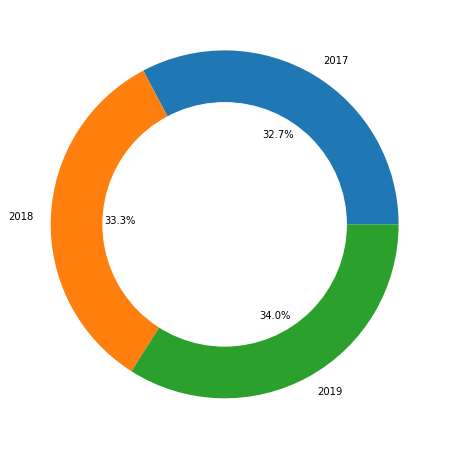

In [15]:
# pie chart for counts of records in each year 
group = df_com.groupby(by = 'yearID').count()

fig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.pie(group['G'], labels=group.index, autopct='%0.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

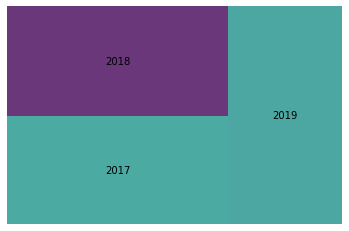

In [16]:
    # pip install squarify (algorithm for )

# tree chart for counts of records in each year 
squarify.plot(sizes=group['G'], label=group.index, alpha=.8 )
plt.axis('off')
plt.show()

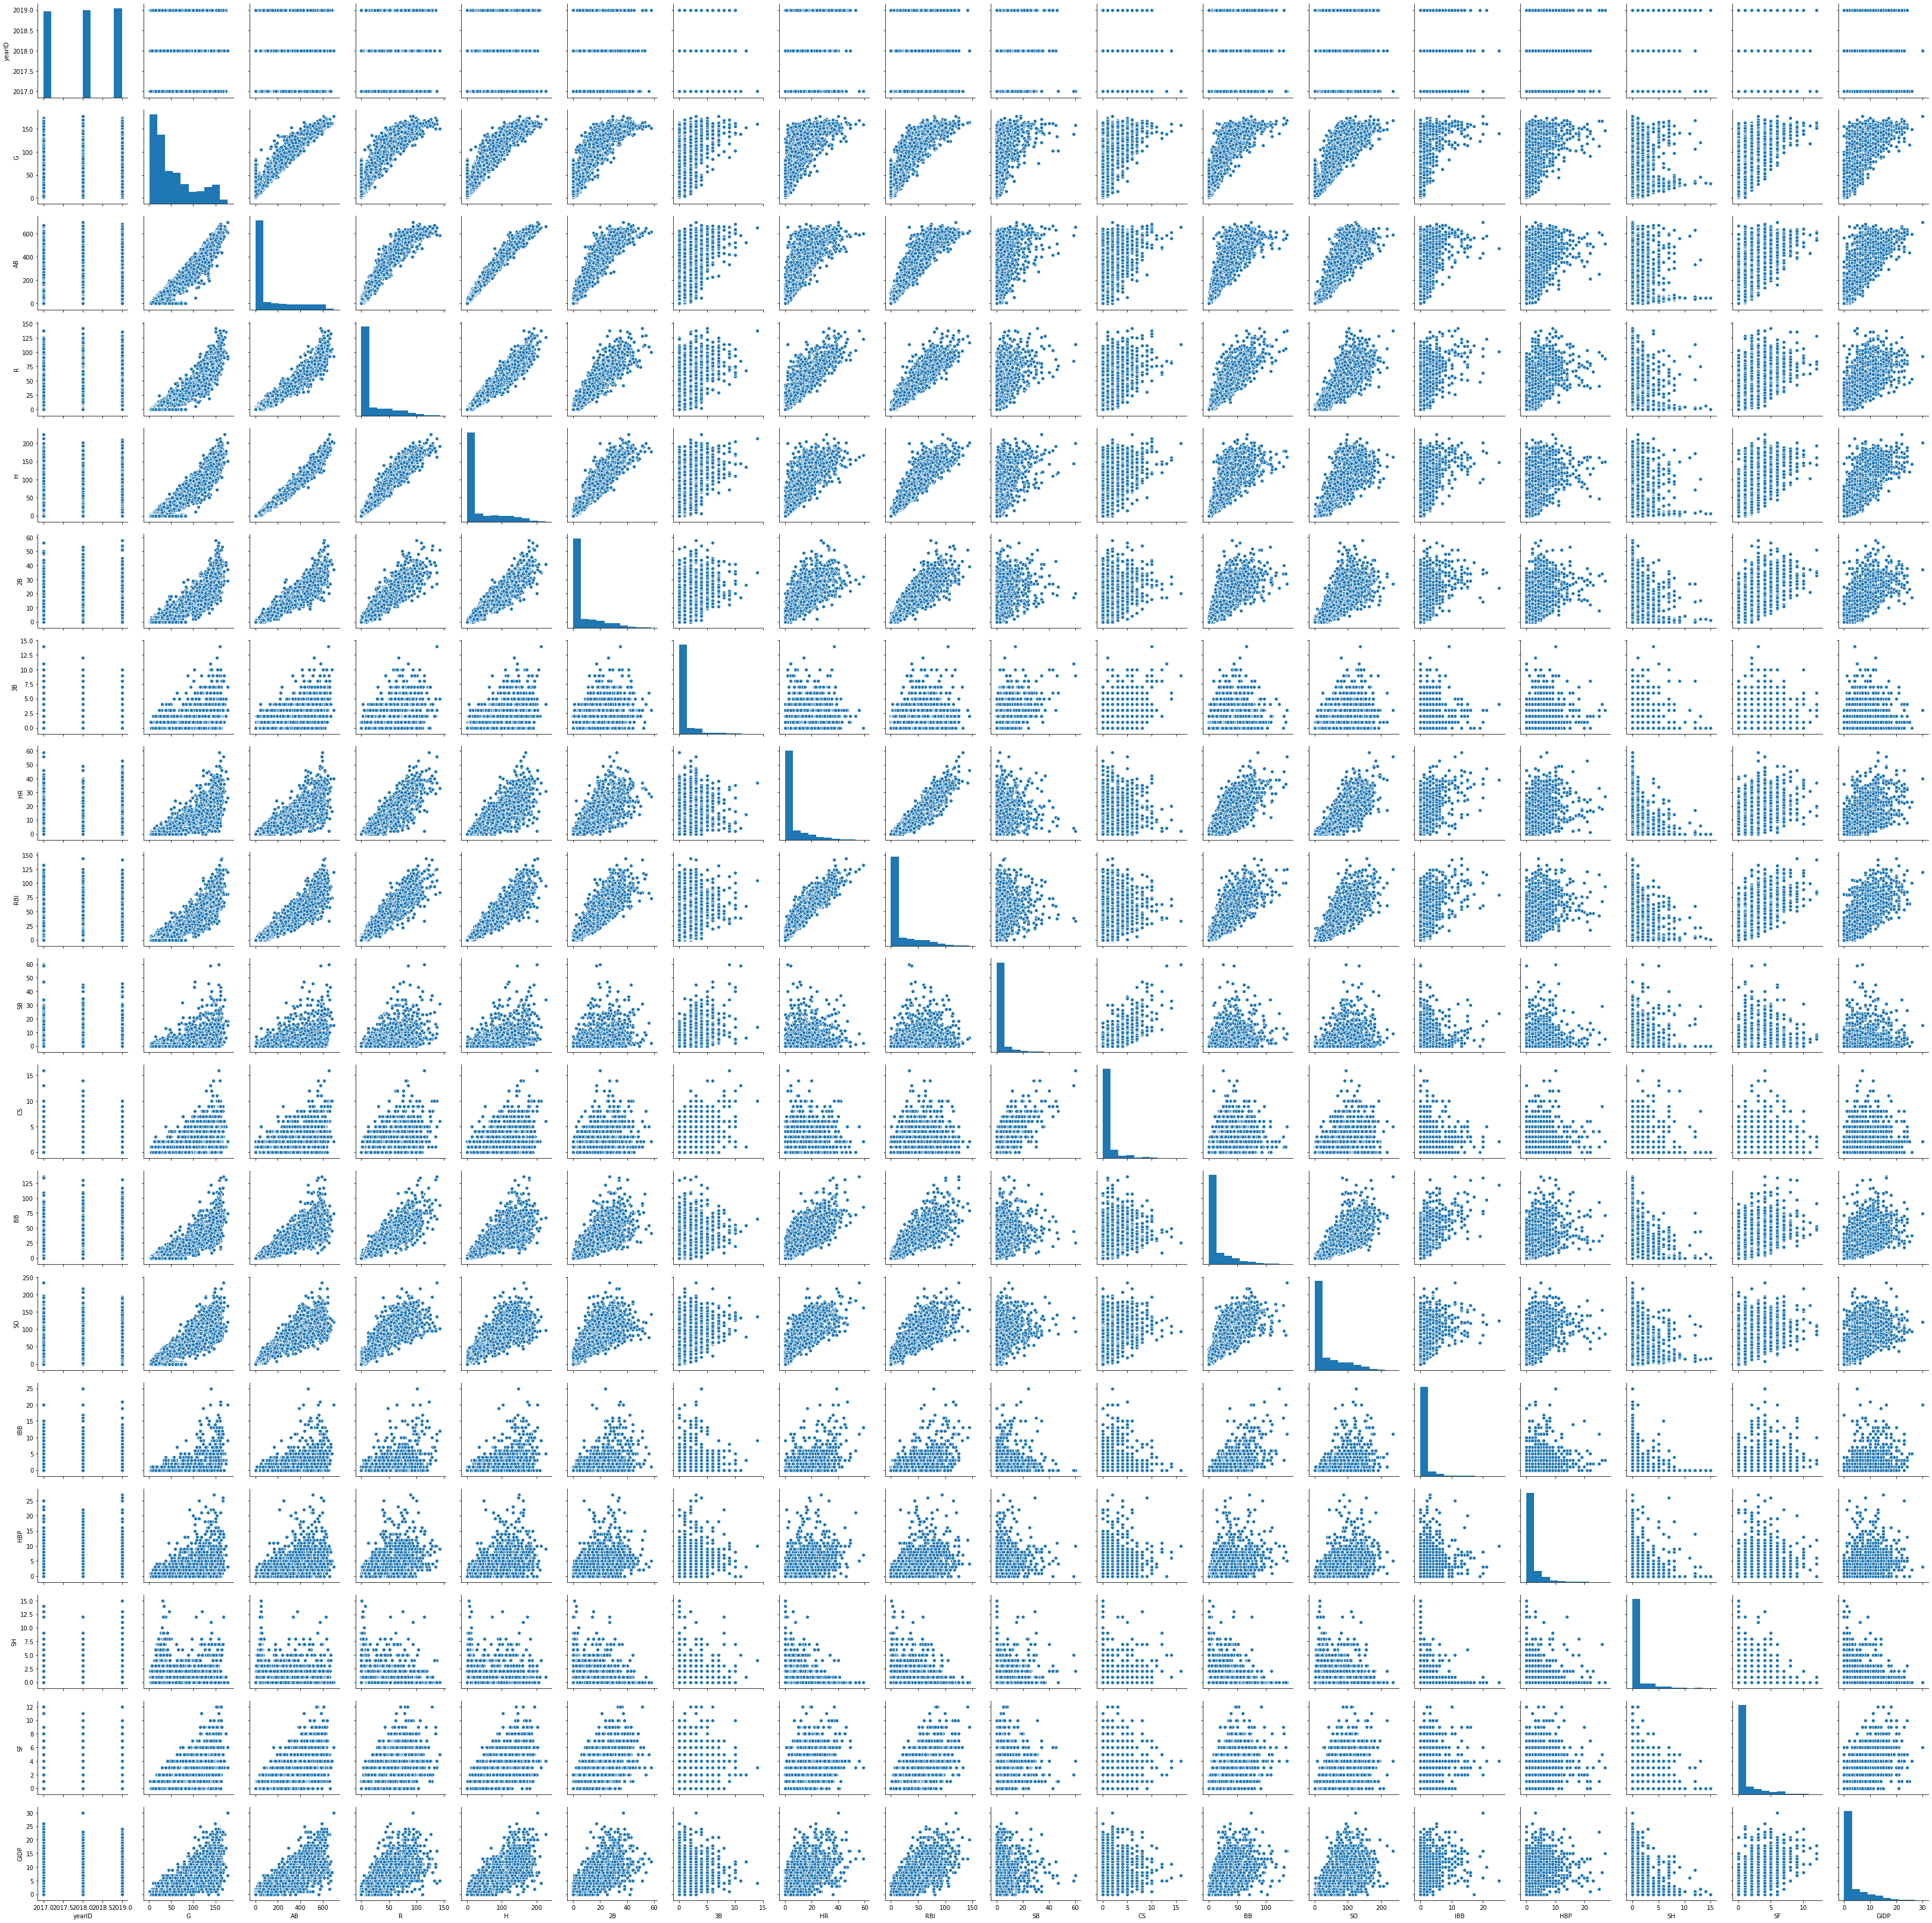

In [17]:
sns.pairplot(df_com) 
plt.show()

In [18]:
df_com.corr()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
yearID,1.000000,-0.011314,-0.008413,-0.000030,-0.010424,-0.004924,-0.010230,0.014486,0.000766,-0.019733,-0.025664,-0.007866,0.007752,-0.038758,0.013953,-0.035445,-0.010408,-0.031190
G,-0.011314,1.000000,0.914239,0.888474,0.901970,0.874443,0.613757,0.804659,0.872690,0.557280,0.613680,0.837754,0.866581,0.567867,0.662819,0.112249,0.734385,0.801689
AB,-0.008413,0.914239,1.000000,0.972769,0.990652,0.959769,0.674903,0.882693,0.955902,0.613759,0.671278,0.902769,0.941044,0.609770,0.713868,0.127015,0.802734,0.878753
R,-0.000030,0.888474,0.972769,1.000000,0.977868,0.953679,0.679123,0.917785,0.958720,0.639875,0.672685,0.928279,0.918022,0.636618,0.715321,0.088585,0.778230,0.832171
H,-0.010424,0.901970,0.990652,0.977868,1.000000,0.967317,0.682322,0.882014,0.958270,0.622957,0.672812,0.892023,0.909663,0.623298,0.703188,0.104262,0.800788,0.876616
2B,-0.004924,0.874443,0.959769,0.953679,0.967317,1.000000,0.647702,0.859583,0.937894,0.578937,0.635407,0.873542,0.882197,0.612553,0.686725,0.074086,0.788388,0.838465
3B,-0.010230,0.613757,0.674903,0.679123,0.682322,0.647702,1.000000,0.515502,0.596821,0.656468,0.669264,0.575213,0.620103,0.369710,0.479990,0.152913,0.501948,0.491636
HR,0.014486,0.804659,0.882693,0.917785,0.882014,0.859583,0.515502,1.000000,0.954200,0.454577,0.495726,0.877406,0.885703,0.654491,0.658011,-0.013617,0.719567,0.777930
RBI,0.000766,0.872690,0.955902,0.958720,0.958270,0.937894,0.596821,0.954200,1.000000,0.515568,0.567710,0.904685,0.911817,0.659396,0.689575,0.040215,0.814965,0.860249
SB,-0.019733,0.557280,0.613759,0.639875,0.622957,0.578937,0.656468,0.454577,0.515568,1.000000,0.809799,0.532638,0.555238,0.340957,0.434846,0.188482,0.435900,0.442073


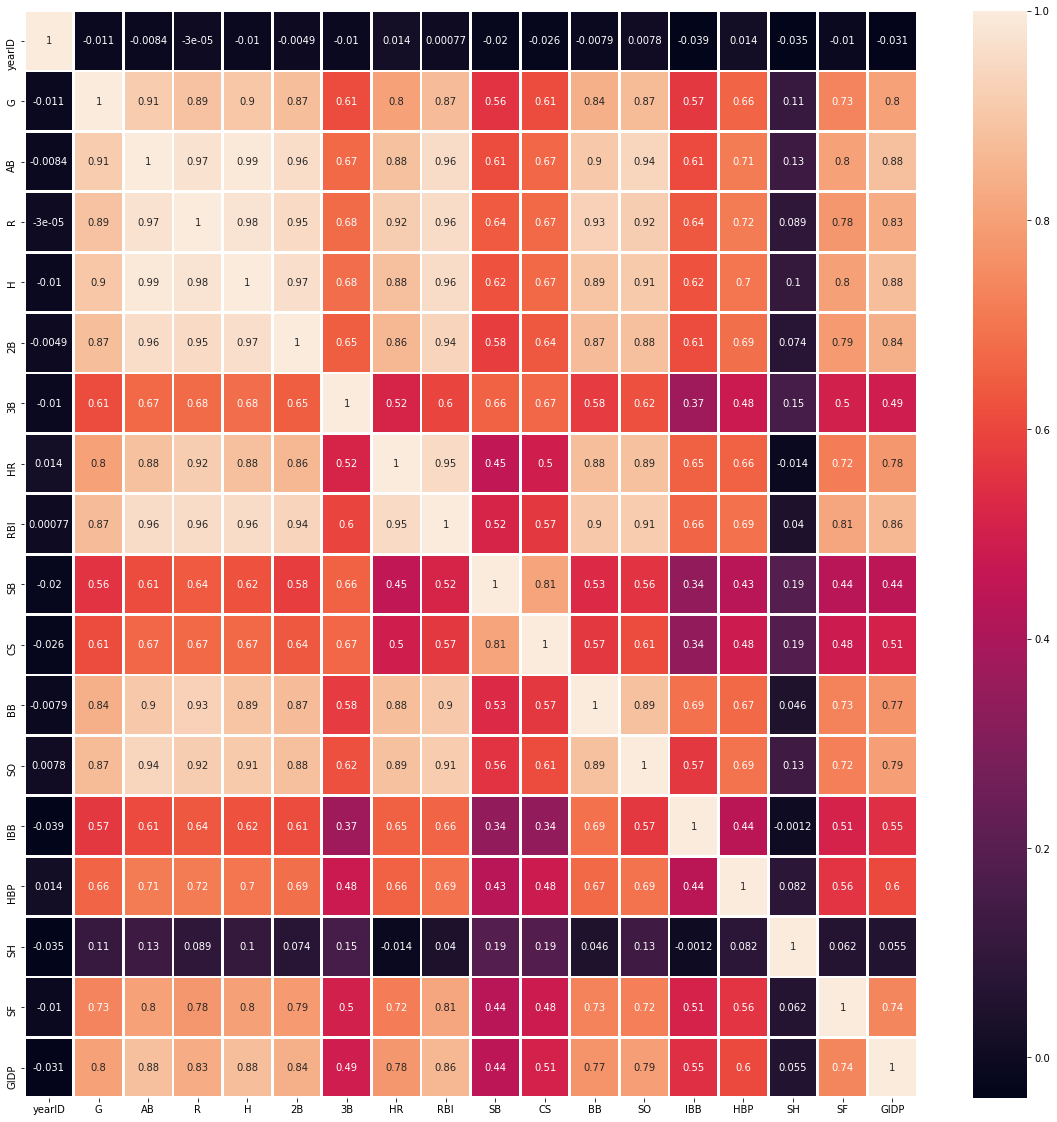

In [19]:
plt.figure(figsize = [20, 20])
sns.heatmap(df_com.corr(), annot = True, linecolor='white',linewidths = 2)

### * Model Building
1. Apply PCA to find the two PCs which bring most information of the data
2. Apply DBSCAN to group the players and find the outliers
3. Apply LOF to group the players and find the outliers

In [20]:
# apply PCA
features = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
            'IBB', 'HBP', 'SH', 'SF', 'GIDP'] 

# Separating out the features
x = df_inc.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# dimensionality reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index = df_inc.index)
#principalDf.head()
finalDf = principalDf

In [21]:
# the weight of variables in each principal component
pca.components_
# PC1 measures slugging percentage 
# PC2 measures speed 

array([[ 0.28715294,  0.29388896,  0.29341127,  0.29222502,  0.2846063 ,
         0.18149479,  0.26421356,  0.28617516,  0.15658126,  0.17566938,
         0.26326806,  0.26134751,  0.19941297,  0.17993756, -0.10393831,
         0.24502299,  0.24097344],
       [ 0.01147169,  0.0185848 ,  0.0268861 ,  0.02543451, -0.01329169,
         0.4236759 , -0.19790697, -0.14491867,  0.53271398,  0.51473545,
        -0.10845596, -0.02720679, -0.17056488, -0.03031999,  0.3593501 ,
        -0.10012228, -0.16702809]])

In [22]:
# The proportion that PCA explains
pca.explained_variance_ratio_

array([0.65840547, 0.11656534])

In [23]:
# Compare the PCs with advanced metrics
features_comparePC = ['TB', 'BA', 'OBP', 'SLG', 'OPS', 'TA', 'ISO', 'SECA', 'RC', 'RC27']

# change column names of finaldf
df_takePC = finalDf[finalDf.columns[:2]]
df_takePC.columns = ['P1', 'P2']
4
# DF with Advanced metrics and PCs
df_comparePC = df_inc.loc[:, features_comparePC]
df_comparePC['P1'] = df_comparePC.index.map(df_takePC['P1'])
df_comparePC['P2'] = df_comparePC.index.map(df_takePC['P2'])

df_comparePC_corr = df_comparePC.corr(method = 'pearson')
df_comparePC_corr = df_comparePC_corr.round(2)
df_comparePC_corr

,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27,P1,P2
TB,1.00,0.66,0.66,0.76,0.75,0.76,0.72,0.70,0.98,0.61,0.99,-0.06
BA,0.66,1.00,0.92,0.86,0.90,0.81,0.68,0.65,0.65,0.71,0.66,-0.05
OBP,0.66,0.92,1.00,0.87,0.94,0.89,0.74,0.80,0.68,0.74,0.68,-0.13
SLG,0.76,0.86,0.87,1.00,0.99,0.93,0.96,0.90,0.75,0.74,0.74,-0.22
OPS,0.75,0.90,0.94,0.99,1.00,0.95,0.92,0.90,0.75,0.76,0.75,-0.19
TA,0.76,0.81,0.89,0.93,0.95,1.00,0.89,0.93,0.78,0.79,0.76,-0.18
ISO,0.72,0.68,0.74,0.96,0.92,0.89,1.00,0.93,0.72,0.68,0.70,-0.28
SECA,0.70,0.65,0.80,0.90,0.90,0.93,0.93,1.00,0.72,0.70,0.70,-0.24
RC,0.98,0.65,0.68,0.75,0.75,0.78,0.72,0.72,1.00,0.59,0.97,-0.07
RC27,0.61,0.71,0.74,0.74,0.76,0.79,0.68,0.70,0.59,1.00,0.63,-0.07


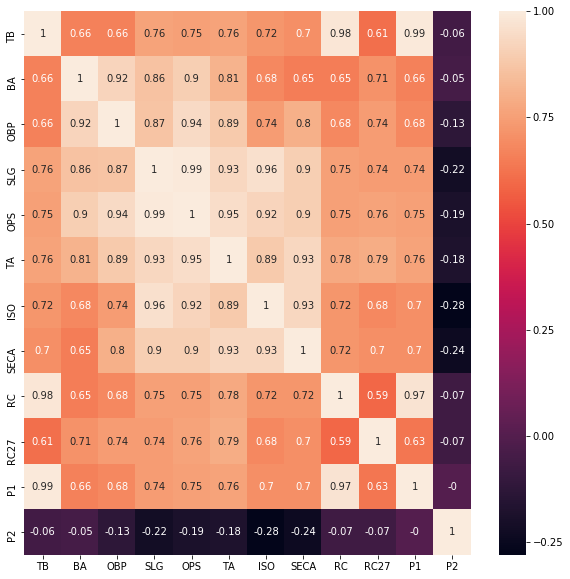

In [24]:
plt.figure(figsize = [10, 10])
sns.heatmap(df_comparePC_corr, annot = True)

In [25]:
# PCs validation -- add speed
df_speed = pd.read_csv('sprint_speed.csv')
df_speed.rename(columns = {' first_name':'nameFirst', 'last_name':'nameLast'}, inplace = True)

df_speed[df_speed.duplicated(subset=['nameFirst','nameLast'], keep=False)]
df_speed = df_speed.drop([315, 481])
df_speed

# df with PCs and the current metrics
df_comparePC = df_inc.loc[:, features_comparePC]
df_comparePC['P1'] = df_comparePC.index.map(df_takePC['P1'])
df_comparePC['P2'] = df_comparePC.index.map(df_takePC['P2'])
df_comparePC['nameFirst'] = df_comparePC.index.map(df_batter.set_index('playerID')['nameFirst'])
df_comparePC['nameLast'] = df_comparePC.index.map(df_batter.set_index('playerID')['nameLast'])

In [26]:
# clean the name in df
df_speed.nameFirst = df_speed.nameFirst.str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

df_speed.nameFirst = df_speed.nameFirst.str.lstrip()

df_comparePC.nameFirst = \
df_comparePC.nameFirst.str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

df_comparePC.nameFirst = df_comparePC.nameFirst.str.lstrip()

In [27]:
# merge speed and the comparePC df
df_PCWithSpeed = pd.merge(df_comparePC, df_speed,  how='left', left_on=['nameLast', 'nameFirst'], right_on = ['nameLast', 'nameFirst'])

In [28]:
# check nan
df_PCWithSpeed.isnull().sum()

TB                    0
BA                    0
OBP                   0
SLG                   0
OPS                   0
TA                    0
ISO                   0
SECA                  0
RC                    0
RC27                  0
P1                    0
P2                    0
nameFirst             0
nameLast              0
player_id            68
team_id              68
team                 68
position             68
age                 456
competitive_runs     68
hp_to_1b             72
sprint_speed         68
dtype: int64

In [29]:
df_PCWithSpeed.corr(method = 'pearson')

,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27,P1,P2,player_id,team_id,age,competitive_runs,hp_to_1b,sprint_speed
TB,1.000000,0.663297,0.662206,0.759631,0.751873,0.759828,0.724953,0.698247,0.984939,0.610164,9.867777e-01,-6.130028e-02,-0.100492,0.000255,NaN,0.831127,-0.052532,0.040166
BA,0.663297,1.000000,0.916369,0.858143,0.903248,0.810161,0.681710,0.648259,0.653298,0.706455,6.638743e-01,-4.730691e-02,-0.044456,0.006931,NaN,0.535290,0.009424,-0.039614
OBP,0.662206,0.916369,1.000000,0.867858,0.936297,0.893145,0.739662,0.804144,0.682880,0.738001,6.827428e-01,-1.314010e-01,-0.059033,0.020951,NaN,0.481650,0.069626,-0.086731
SLG,0.759631,0.858143,0.867858,1.000000,0.986614,0.933453,0.959699,0.902008,0.751573,0.743268,7.430625e-01,-2.155141e-01,0.033625,0.039336,NaN,0.441757,0.077440,-0.070360
OPS,0.751873,0.903248,0.936297,0.986614,1.000000,0.947705,0.916596,0.896926,0.752917,0.764228,7.467645e-01,-1.942907e-01,0.006726,0.034799,NaN,0.481833,0.078388,-0.077709
TA,0.759828,0.810161,0.893145,0.933453,0.947705,1.000000,0.889648,0.932689,0.779628,0.790530,7.569767e-01,-1.806452e-01,0.066264,-0.003350,NaN,0.447397,-0.013493,0.021021
ISO,0.724953,0.681710,0.739662,0.959699,0.916596,0.889648,1.000000,0.934107,0.718370,0.677224,7.004463e-01,-2.828524e-01,0.059678,0.043641,NaN,0.316945,0.094079,-0.072661
SECA,0.698247,0.648259,0.804144,0.902008,0.896926,0.932689,0.934107,1.000000,0.721493,0.696886,6.987360e-01,-2.428201e-01,0.064040,0.014341,NaN,0.295538,0.028198,-0.000956
RC,0.984939,0.653298,0.682880,0.751573,0.752917,0.779628,0.718370,0.721493,1.000000,0.590281,9.742679e-01,-6.851634e-02,-0.094212,-0.010315,NaN,0.799737,-0.064584,0.051005
RC27,0.610164,0.706455,0.738001,0.743268,0.764228,0.790530,0.677224,0.696886,0.590281,1.000000,6.291026e-01,-6.886288e-02,0.045981,0.063919,NaN,0.379950,-0.024628,0.030473


In [30]:
## apply DBSCAN

# select only 4 columns in the df
df_pca = finalDf[finalDf.columns[:2]]

# rename the columns
df_pca.columns = ['P1', 'P2']

X = df_pca
db = DBSCAN(eps=0.8, min_samples=20).fit(finalDf) #.fit(finalDf.iloc[:, :-1])

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#n_noise_ = list(labels).count(-1)

realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
n_noise_ = list(labels).count(-1)

#print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of clusters: %d' % realClusterNum)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 113


In [31]:
# df with dbscan labels

df_compare = finalDf.copy()
df_compare.columns = ['P1', 'P2']
df_compare['dbscan'] = labels
df_compare.head()

,P1,P2,dbscan
playerID,,,
abreujo02,6.150487,-2.067652,-1
adamsma01,0.421648,-1.627086,0
adducji02,-3.880876,0.080513,0
adriaeh01,-0.977669,0.631806,0
aguilje01,2.517261,-2.162508,-1


In [32]:
# labels of outliers and the datapoints in the cluster
set(labels)

{-1, 0}

In [33]:
# the number of data points in each label
Counter(labels)

Counter({-1: 113, 0: 343})

Text(0, 0.5, 'Principal Component 2')

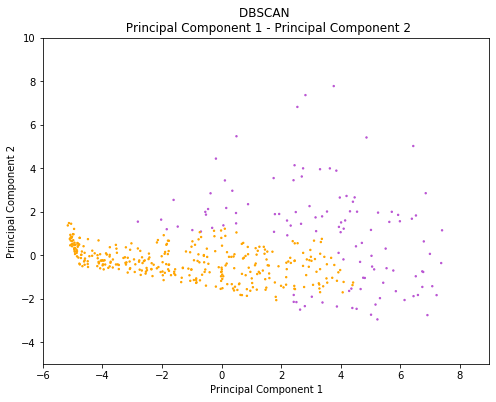

In [34]:
# Visualisation of DBSCAN

DIM_PCA_toPlot = ('P1', 'P2')
colors = ['orange', 'red', 'green', "blue", 'black', 'mediumorchid']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.figure(figsize = (8, 6))
plt.xlim((-6, 9))
plt.ylim((-5, 10))
plt.scatter(df_pca[DIM_PCA_toPlot[0]], df_pca[DIM_PCA_toPlot[1]], c=vectorizer(labels), s = 2)
plt.title("DBSCAN \n Principal Component 1 - Principal Component 2")
#plt.title("DBSCAN \n%s - %s " %DIM_PCA_toPlot)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")


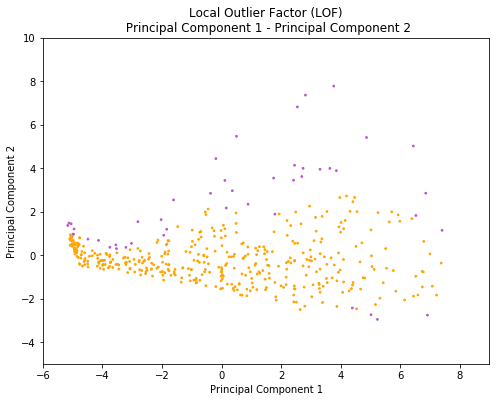

In [35]:
# apply LOF
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

X = df_pca[['P1','P2']].values
y_pred = clf.fit_predict(X)

# number of outliers
n_errors = np.count_nonzero(y_pred == -1)

X_scores = clf.negative_outlier_factor_

DIM_PCA_toPlot = ('P1', 'P2')
colors = ['green','orange', 'mediumorchid']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize = (8, 6))
plt.title("Local Outlier Factor (LOF)\n Principal Component 1 - Principal Component 2")   
plt.scatter(X[:, 0], X[:, 1], c = vectorizer(y_pred), s=3.)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.axis('tight')
plt.xlim((-6, 9))
plt.ylim((-5, 10))

plt.show()

In [36]:
# filter the outlier which are found with LOF and create a df of outliers
df_compare['lof'] = y_pred
df_compare['lof_score'] = X_scores
df_compare

df_outliers = df_compare[(df_compare['lof'] == -1)]
df_outliers.head()

,P1,P2,dbscan,lof,lof_score
playerID,,,,,
allengr01,-2.027965,1.630792,-1,-1,-1.377670
almonab01,-3.213229,0.356165,0,-1,-1.244830
bettsmo01,7.411027,1.138634,-1,-1,-1.251993
blackch02,6.861676,2.845936,-1,-1,-1.381900
bourjpe01,-3.549743,0.469967,0,-1,-1.332139


In [37]:
# number of outliers
df_outliers.shape

(46, 5)

In [38]:
## add the player's information in the outlier df

# map the real outlier with their ID to find who thy are


df_outliers['nameFirst'] = df_outliers.index.map(df_batter.set_index('playerID')['nameFirst'])
df_outliers['nameLast'] = df_outliers.index.map(df_batter.set_index('playerID')['nameLast'])

# rank by lof score
df_outliers1 = df_outliers.sort_values(by = ['lof_score'], ascending = True)

df_outliers1

,P1,P2,dbscan,lof,lof_score,nameFirst,nameLast
playerID,,,,,,,
gordode01,3.770775,7.771829,-1,-1,-2.056930,Dee,Strange-Gordon
kershcl01,-5.127063,1.471851,0,-1,-1.962423,Clayton,Kershaw
hamilbi02,2.820760,7.356978,-1,-1,-1.884130,Billy,Hamilton
teherju01,-5.053128,1.442225,0,-1,-1.875640,Julio,Teheran
maedake01,-5.165417,1.363036,0,-1,-1.824285,Kenta,Maeda
merriwh01,6.443834,5.015534,-1,-1,-1.750847,Whit,Merrifield
smithma05,2.549526,6.813607,-1,-1,-1.718957,Mallex,Smith
mondera02,-0.187838,4.437264,-1,-1,-1.708166,Adalberto,Mondesi
deshide02,0.502393,5.464362,-1,-1,-1.687233,Delino,DeShields


In [39]:
## top 14 outliers'

df_outlier_output = df_outliers1.copy()
df_outlier_output_with_index = df_outlier_output.reset_index()
df_outlier_output = df_outlier_output.reset_index()
df_outlier_output = df_outlier_output.loc[:, ['P1', 'P2','nameFirst','nameLast', 'lof_score']]

# filter lof score < -1.5
df_outlier_output = df_outlier_output[df_outlier_output['lof_score'] < -1.5]
df_outlier_output = df_outlier_output.round(3)
df_outlier_output.sort_values(by = ['lof_score'], ascending = True)


,P1,P2,nameFirst,nameLast,lof_score
0,3.771,7.772,Dee,Strange-Gordon,-2.057
1,-5.127,1.472,Clayton,Kershaw,-1.962
2,2.821,7.357,Billy,Hamilton,-1.884
3,-5.053,1.442,Julio,Teheran,-1.876
4,-5.165,1.363,Kenta,Maeda,-1.824
5,6.444,5.016,Whit,Merrifield,-1.751
6,2.550,6.814,Mallex,Smith,-1.719
7,-0.188,4.437,Adalberto,Mondesi,-1.708
8,0.502,5.464,Delino,DeShields,-1.687
9,-2.811,1.538,Travis,Jankowski,-1.682


In [40]:
## top 14 outliers' sabermetrics

df_outlier_output_with_index = df_outlier_output_with_index[df_outlier_output_with_index['lof_score'] < -1.5]
df_outlier_output_with_index = df_outlier_output_with_index.sort_values(by = ['lof_score'], ascending = True)
df_outlier_output_advmetrics = df_inc.loc[df_outlier_output_with_index.playerID]

# sabermetrics
saberfeatures = ['TB', 'BA', 'OBP', 'SLG', 'OPS', 'TA','ISO', 'SECA', 'RC', 'RC27']

df_outlier_output_advmetrics = df_outlier_output_advmetrics.loc[:, saberfeatures]

df_outlier_output_advmetrics

,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27
playerID,,,,,,,,,,
gordode01,220.33,0.28,0.31,0.41,0.72,0.67,0.13,0.21,69.77,0.01
kershcl01,11.33,0.16,0.23,0.21,0.44,0.37,0.05,0.14,3.56,0.00
hamilbi02,174.67,0.23,0.29,0.37,0.66,0.66,0.13,0.28,56.73,0.01
teherju01,9.00,0.14,0.15,0.19,0.34,0.24,0.05,0.06,1.95,0.00
maedake01,8.67,0.16,0.16,0.20,0.36,0.25,0.04,0.04,1.90,0.00
merriwh01,348.00,0.30,0.34,0.55,0.89,0.91,0.25,0.36,120.90,0.01
smithma05,181.33,0.26,0.33,0.43,0.76,0.77,0.17,0.32,63.34,0.01
mondera02,132.33,0.24,0.27,0.47,0.74,0.75,0.23,0.36,39.37,0.01
deshide02,139.67,0.24,0.32,0.39,0.71,0.73,0.15,0.32,50.66,0.01


In [41]:
# find the normal player with similar performance

# map the name of players
df_compare_lof = df_comparePC.copy()
df_compare_lof['nameFirst'] = df_compare_lof.index.map(df_batter.set_index('playerID')['nameFirst'])
df_compare_lof['nameLast'] = df_compare_lof.index.map(df_batter.set_index('playerID')['nameLast'])
ls_drop = df_outlier_output_with_index.playerID.to_list()
df_compare_lof.drop(ls_drop, inplace = True) 

# filter the players with similar performance
df_compare_lof = df_compare_lof[(2.5 < df_compare_lof['P1']) & (df_compare_lof['P1'] < 3.8)
& (df_compare_lof['P2'] < 3)].sort_values(['P1'], ascending=[False])
df_compare_lof

,TB,BA,OBP,SLG,OPS,TA,ISO,SECA,RC,RC27,P1,P2,nameFirst,nameLast
playerID,,,,,,,,,,,,,,
brantmi02,294.00,0.30,0.36,0.55,0.91,0.92,0.25,0.36,104.84,0.01,3.790530,-0.455122,Michael,Brantley
longoev01,266.67,0.25,0.30,0.52,0.82,0.78,0.26,0.34,79.28,0.01,3.720933,-1.044085,Evan,Longoria
keplema01,294.67,0.24,0.32,0.56,0.88,0.88,0.32,0.44,96.73,0.01,3.683665,-0.126311,Max,Kepler
hoskirh01,268.33,0.24,0.37,0.65,1.02,1.13,0.41,0.61,102.88,0.01,3.553215,-1.267260,Rhys,Hoskins
anderti01,289.00,0.28,0.30,0.53,0.83,0.80,0.25,0.31,83.98,0.01,3.544941,2.002829,Tim,Anderson
chapmma01,299.33,0.25,0.33,0.63,0.96,0.97,0.37,0.48,100.76,0.01,3.540717,-0.423039,Matt,Chapman
dejonpa01,279.33,0.25,0.31,0.58,0.89,0.89,0.32,0.41,87.92,0.01,3.526977,-1.073393,Paul,DeJong
gordoal01,223.33,0.24,0.32,0.43,0.75,0.72,0.19,0.30,74.25,0.01,3.455522,-0.080667,Alex,Gordon
grandya01,271.67,0.24,0.34,0.57,0.91,0.93,0.33,0.49,95.01,0.01,3.416556,-1.436133,Yasmani,Grandal
